In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *
LetsPlot.setup_html()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

torch.set_printoptions(precision=None, threshold=np.inf,
                       edgeitems=None, linewidth=None,
                       profile=None, sci_mode=False)

import copy, time

In [3]:
from torchvision import models, transforms

In [4]:
def load_image(input):
    image = Image.open(input)
    image = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()])(image).unsqueeze(0)
    return image.to(device, torch.float)


In [5]:
def show_image(tensor, title=None):
    plt.figure()
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [6]:
def gram_matrix(x):
    Nx, Cx, Hx, Wx = x.size()
    x_reshaped = x.view(Nx * Cx,  Hx * Wx)
    gram = torch.mm(x_reshaped,x_reshaped.t())
    return gram.div(Nx * Cx * Hx * Wx)


In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target):
        super().__init__()
        self.target = gram_matrix(target).detach()

    def forward(self, input):
        gram = gram_matrix(input)
        self.loss = F.mse_loss(gram, self.target)
        return input

In [9]:
class Normalization(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

    def forward(self, image):
        return (image - self.mean) / self.std

In [10]:
def get_style_model_and_losses(cnn, style_img, content_img, layers):
    cnn = copy.deepcopy(cnn)
    
    normalization = Normalization().to(device)
    content_layers, style_layers = layers
    
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [11]:
def run_style_transfer(model, content_img, style_img, input_img):

    style_model, style_losses, content_losses = get_style_model_and_losses(
        model,style_img, content_img, layers)
    
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.001, weight_decay=0.0001)

    for epoch in range(num_epochs):

        torch.cuda.empty_cache()
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        style_model(input_img)
        
        content_score = np.sum([content.loss * alpha for content in content_losses])     
        style_score = np.sum([style.loss * beta for style in style_losses])

        loss = style_score + content_score
        
        loss.backward()
        optimizer.step()

    return input_img.data.clamp_(0, 1)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
layers = (['conv_2'], ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'])

In [14]:
alpha = 1
beta = 1e5
print('Alpha/Beta ratio: {:.0e}'.format(alpha/beta))

Alpha/Beta ratio: 1e-05


In [15]:
num_epochs = 1500

In [16]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

In [17]:
image_style = load_image("./data/images/neural-style/the_great_wave.jpg")
image_content = load_image("./data/images/neural-style/800px-Green_Sea_Turtle_grazing_seagrass.jpg")
image_output = run_style_transfer(vgg19, image_content, image_style, image_content.clone())

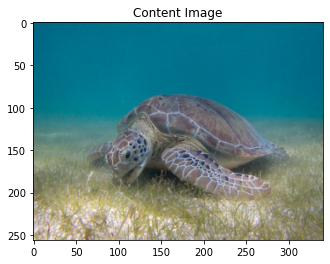

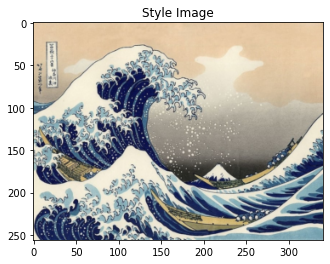

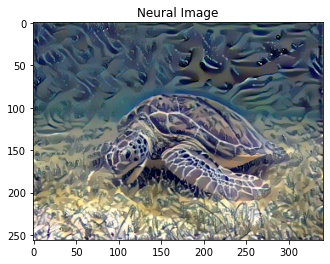

In [18]:
show_image(image_content, 'Content Image')
show_image(image_style, 'Style Image')
show_image(image_output, 'Neural Image')

In [19]:
image_style = load_image("./data/images/neural-style/Der_Schrei.jpg")
image_content = load_image("./data/images/neural-style/Tuebingen_Neckarfront.jpg")
image_output = run_style_transfer(vgg19, image_content, image_style, image_content.clone())

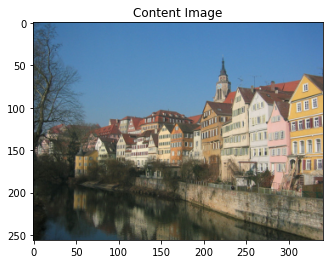

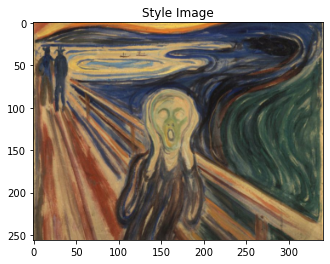

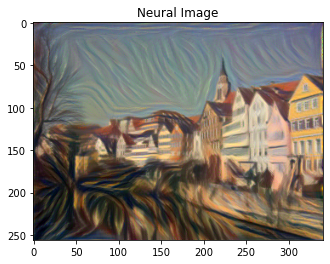

In [20]:
show_image(image_content, 'Content Image')
show_image(image_style, 'Style Image')
show_image(image_output, 'Neural Image')

In [21]:
image_style = load_image("./data/images/neural-style/starry_night.jpg")
image_content = load_image("./data/images/neural-style/Tuebingen_Neckarfront.jpg")
image_output = run_style_transfer(vgg19, image_content, image_style, image_content.clone())

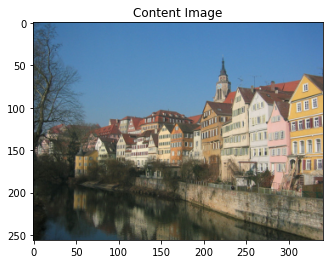

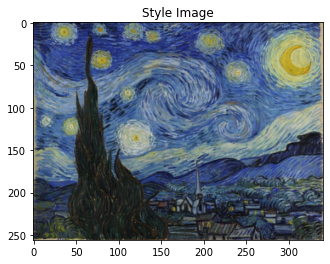

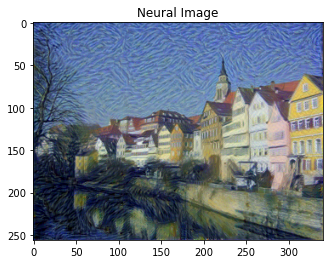

In [22]:
show_image(image_content, 'Content Image')
show_image(image_style, 'Style Image')
show_image(image_output, 'Neural Image')

In [23]:
image_style = load_image("./data/images/neural-style/autumn-gold-trees-in-a.jpg")
image_content = load_image("./data/images/neural-style/stevejobs__.jpg")
image_output = run_style_transfer(vgg19, image_content, image_style, image_content.clone())

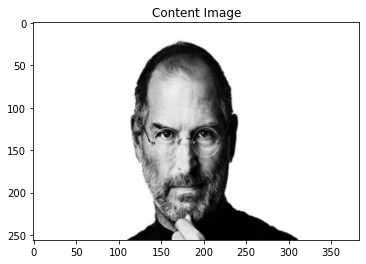

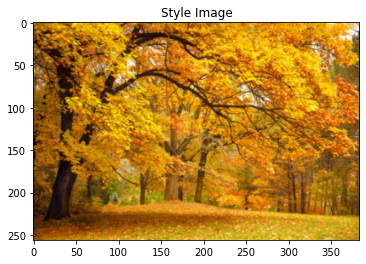

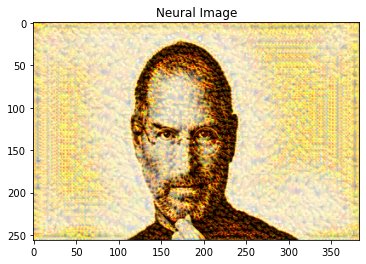

In [24]:
show_image(image_content, 'Content Image')
show_image(image_style, 'Style Image')
show_image(image_output, 'Neural Image')

In [25]:
image_style = load_image("./data/images/neural-style/background_Claude_Monet_Poppy_Field_near_Giverny.jpg")
image_content = load_image("./data/images/neural-style/da_vinci_mona_lisa_.jpg")
image_output = run_style_transfer(vgg19, image_content, image_style, image_content.clone())

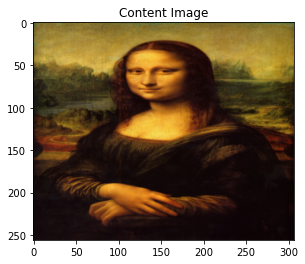

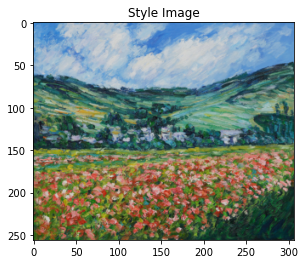

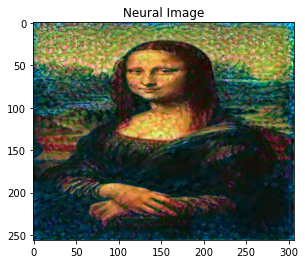

In [26]:
show_image(image_content, 'Content Image')
show_image(image_style, 'Style Image')
show_image(image_output, 'Neural Image')